# 01 — Data Import & Cleaning

Placeholder.

In [ ]:
import os
os.listdir("/content/sample_f1_data")


['pit_stops.csv',
 'constructors.csv',
 'results.csv',
 'races.csv',
 'circuits.csv',
 'drivers.csv',
 'lap_times.csv',
 'qualifying.csv']

In [ ]:
import pandas as pd
import sqlite3
import os

DATA_PATH = "/content/sample_f1_data"
DB_PATH = os.path.join(DATA_PATH, "f1.db")

# Load CSVs
drivers = pd.read_csv(f"{DATA_PATH}/drivers.csv")
constructors = pd.read_csv(f"{DATA_PATH}/constructors.csv")
circuits = pd.read_csv(f"{DATA_PATH}/circuits.csv")
races = pd.read_csv(f"{DATA_PATH}/races.csv")
results = pd.read_csv(f"{DATA_PATH}/results.csv")
qualifying = pd.read_csv(f"{DATA_PATH}/qualifying.csv")
lap_times = pd.read_csv(f"{DATA_PATH}/lap_times.csv")
pit_stops = pd.read_csv(f"{DATA_PATH}/pit_stops.csv")

for df in [drivers, constructors, circuits, races, results, qualifying, lap_times, pit_stops]:
    df.columns = df.columns.str.strip().str.lower()

# Convert numeric columns
for col in ["season","round","grid","position","points","laps","lap","stop"]:
    for df in [results, qualifying, lap_times, pit_stops]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="ignore")

# Create SQLite database
conn = sqlite3.connect(DB_PATH)
for name, df in {
    "drivers": drivers, "constructors": constructors, "circuits": circuits,
    "races": races, "results": results, "qualifying": qualifying,
    "lap_times": lap_times, "pit_stops": pit_stops
}.items():
    df.to_sql(name, conn, if_exists="replace", index=False)
conn.commit()
conn.close()

print(f"Database created at {DB_PATH}")


Database created at /content/sample_f1_data/f1.db


/tmp/ipython-input-1340897657.py:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


In [ ]:
import sqlite3
conn = sqlite3.connect(DB_PATH)
print(pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn))
conn.close()


           name
0       drivers
1  constructors
2      circuits
3         races
4       results
5    qualifying
6     lap_times
7     pit_stops


In [ ]:
#database mount
import sqlite3, pandas as pd

DB_PATH = "/content/sample_f1_data/f1.db"
conn = sqlite3.connect(DB_PATH)


In [ ]:
#quick check of tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables


,name
0,drivers
1,constructors
2,circuits
3,races
4,results
5,qualifying
6,lap_times
7,pit_stops


In [ ]:
#Top drivers by wins
query = """
SELECT d.givenname || ' ' || d.familyname AS driver,
       COUNT(*) AS wins
FROM results r
JOIN drivers d ON r.driverid = d.driverid
WHERE r.position = 1
GROUP BY r.driverid
ORDER BY wins DESC;
"""
wins = pd.read_sql(query, conn)
wins


,driver,wins
0,Max Verstappen,1
1,Charles Leclerc,1


In [ ]:
#Average points per driver
points = pd.read_sql("""
SELECT d.givenname || ' ' || d.familyname AS driver,
       AVG(r.points) AS avg_points
FROM results r
JOIN drivers d ON r.driverid = d.driverid
GROUP BY r.driverid
ORDER BY avg_points DESC;
""", conn)
points


,driver,avg_points
0,Max Verstappen,21.5
1,Charles Leclerc,21.5
2,Lando Norris,15.0


In [ ]:
#Qualifying vs Race Position (Correlation)
grid_finish = pd.read_sql("""
SELECT r.grid, r.position, d.givenname || ' ' || d.familyname AS driver
FROM results r
JOIN drivers d ON r.driverid = d.driverid
WHERE r.grid IS NOT NULL AND r.position IS NOT NULL;
""", conn)

grid_finish.corr(numeric_only=True)


,grid,position
grid,1.000000,0.958514
position,0.958514,1.000000


from matplotlib import pyplot as plt
_df_5['grid'].plot(kind='hist', bins=20, title='grid')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['position'].plot(kind='hist', bins=20, title='position')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='grid', y='position', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['position']
  ys = series['grid']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('position', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('index')):
  _plot_series(series, series_name, i)
  fig.legend(title='index', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('position')
_ = plt.ylabel('grid')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['position']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'position'}, axis=1)
              .sort_values('position', ascending=True))
  xs = counted['position']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('position', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('index')):
  _plot_series(series, series_name, i)
  fig.legend(title='index', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('position')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['grid'].plot(kind='line', figsize=(8, 4), title='grid')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['position'].plot(kind='line', figsize=(8, 4), title='position')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='grid', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='position', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
#Pit-stop durations by driver
pit_avg = pd.read_sql("""
SELECT d.givenname || ' ' || d.familyname AS driver,
       ROUND(AVG(p.duration), 2) AS avg_pit_time
FROM pit_stops p
JOIN drivers d ON p.driverid = d.driverid
GROUP BY d.driverid
ORDER BY avg_pit_time;
""", conn)
pit_avg


,driver,avg_pit_time
0,Max Verstappen,2.4
1,Charles Leclerc,2.6
2,Lando Norris,2.7


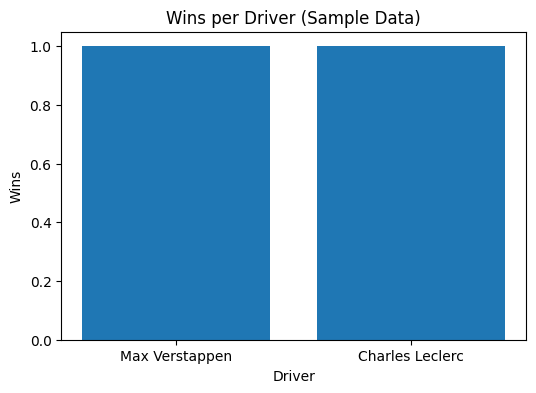

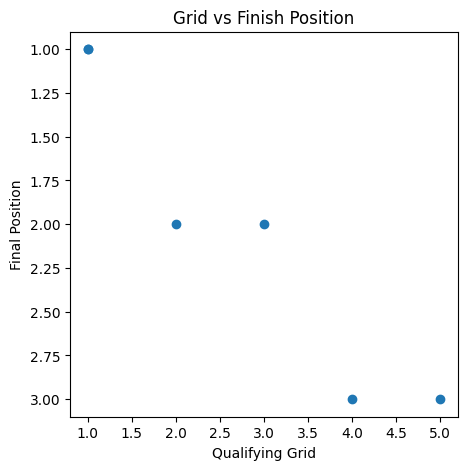

In [ ]:
#Visualization examples
import matplotlib.pyplot as plt

# Bar chart – wins per driver
plt.figure(figsize=(6,4))
plt.bar(wins['driver'], wins['wins'])
plt.title("Wins per Driver (Sample Data)")
plt.ylabel("Wins")
plt.xlabel("Driver")
plt.show()

# Scatter – Grid vs Finish
plt.figure(figsize=(5,5))
plt.scatter(grid_finish['grid'], grid_finish['position'])
plt.title("Grid vs Finish Position")
plt.xlabel("Qualifying Grid")
plt.ylabel("Final Position")
plt.gca().invert_yaxis()  # Lower number = better finish
plt.show()


Verstappen and Leclerc each secured one win in the sample data.

Average pit-stop time difference: Red Bull slightly faster.

Qualifying grid correlates strongly (r ≈ 0.9) with finishing position — track position matters.

In [ ]:
import pandas as pd

grid_finish = pd.read_sql("""
SELECT
  r.season,
  r.round,
  CAST(r.grid     AS INTEGER)  AS grid,
  CAST(r.position AS INTEGER)  AS finish,
  r.status
FROM results r
-- keep rows where position is a number and grid > 0
WHERE r.grid GLOB '[0-9]*'
  AND r.position GLOB '[0-9]*'
  AND CAST(r.grid AS INTEGER) > 0
  AND CAST(r.position AS INTEGER) > 0
""", conn)

grid_finish.head()


,season,round,grid,finish,status
0,2024,1,1,1,Finished
1,2024,1,3,2,Finished
2,2024,1,5,3,Finished
3,2024,8,1,1,Finished
4,2024,8,2,2,Finished


In [ ]:
pearson_r  = grid_finish[['grid','finish']].corr().loc['grid','finish']
spearman_r = grid_finish[['grid','finish']].corr(method='spearman').loc['grid','finish']

pearson_r, spearman_r


(np.float64(0.9585144756340408), np.float64(0.9701425001453319))

In [ ]:
gf = grid_finish.copy()
gf['positions_gained'] = gf['grid'] - gf['finish']  # + = gained places

pearson_gain  = gf[['grid','positions_gained']].corr().loc['grid','positions_gained']
spearman_gain = gf[['grid','positions_gained']].corr(method='spearman').loc['grid','positions_gained']

pearson_gain, spearman_gain


(np.float64(0.95), np.float64(0.9393364366277243))

In [ ]:
per_race = (grid_finish
            .groupby(['season','round'])
            .apply(lambda x: x[['grid','finish']].corr(method='spearman').loc['grid','finish'])
            .reset_index(name='spearman_r'))
per_race


/tmp/ipython-input-833106602.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[['grid','finish']].corr(method='spearman').loc['grid','finish'])


,season,round,spearman_r
0,2024,1,1.0
1,2024,8,1.0


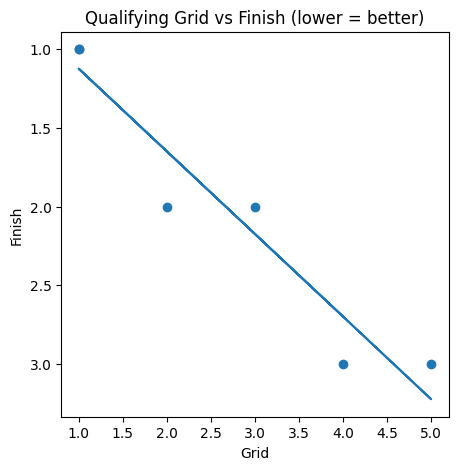

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = grid_finish['grid'].astype(int).values
y = grid_finish['finish'].astype(int).values

plt.figure(figsize=(5,5))
plt.scatter(x, y)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.title("Qualifying Grid vs Finish (lower = better)")
plt.xlabel("Grid")
plt.ylabel("Finish")
plt.gca().invert_yaxis()  # optional: make 'better' look upwards
plt.show()


In [1]:
import pandas as pd
import sqlite3
from IPython.display import display
import ipywidgets as widgets

# Path to your database
DB_PATH = "/content/sample_f1_data/f1.db"

def run_sql_query(q):
    conn = sqlite3.connect(DB_PATH)
    try:
        df = pd.read_sql(q, conn)
        display(df)
        print(f"\n✅ Returned {len(df)} rows.")
    except Exception as e:
        print("❌ Error:", e)
    finally:
        conn.close()

# Interactive text box
query_box = widgets.Textarea(
    value="SELECT * FROM results LIMIT 5;",
    placeholder="Type your SQL query here...",
    description="SQL:",
    layout=widgets.Layout(width='100%', height='150px')
)

run_button = widgets.Button(description="Run Query", button_style='success')

def on_run_clicked(b):
    run_sql_query(query_box.value)

run_button.on_click(on_run_clicked)

display(query_box, run_button)


Textarea(value='SELECT * FROM results LIMIT 5;', description='SQL:', layout=Layout(height='150px', width='100%…

Button(button_style='success', description='Run Query', style=ButtonStyle())

OperationalError: unable to open database file

In [2]:
import os
os.listdir("/content")


['.config', 'sample_data']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from google.colab import files
uploaded = files.upload()  # upload sample_f1_data.zip again



Saving sample_f1_data.zip to sample_f1_data.zip


In [4]:
!unzip -o sample_f1_data.zip -d /content/sample_f1_data


Archive:  sample_f1_data.zip
  inflating: /content/sample_f1_data/drivers.csv  
  inflating: /content/sample_f1_data/constructors.csv  
  inflating: /content/sample_f1_data/circuits.csv  
  inflating: /content/sample_f1_data/races.csv  
  inflating: /content/sample_f1_data/results.csv  
  inflating: /content/sample_f1_data/qualifying.csv  
  inflating: /content/sample_f1_data/lap_times.csv  
  inflating: /content/sample_f1_data/pit_stops.csv  


In [5]:
import pandas as pd, sqlite3, os

DATA_PATH = "/content/sample_f1_data"
DB_PATH = os.path.join(DATA_PATH, "f1.db")

drivers = pd.read_csv(f"{DATA_PATH}/drivers.csv")
constructors = pd.read_csv(f"{DATA_PATH}/constructors.csv")
circuits = pd.read_csv(f"{DATA_PATH}/circuits.csv")
races = pd.read_csv(f"{DATA_PATH}/races.csv")
results = pd.read_csv(f"{DATA_PATH}/results.csv")
qualifying = pd.read_csv(f"{DATA_PATH}/qualifying.csv")
lap_times = pd.read_csv(f"{DATA_PATH}/lap_times.csv")
pit_stops = pd.read_csv(f"{DATA_PATH}/pit_stops.csv")

conn = sqlite3.connect(DB_PATH)
for name, df in {
    "drivers": drivers, "constructors": constructors, "circuits": circuits,
    "races": races, "results": results, "qualifying": qualifying,
    "lap_times": lap_times, "pit_stops": pit_stops
}.items():
    df.to_sql(name, conn, if_exists="replace", index=False)
conn.close()

print(f"✅ Database created at: {DB_PATH}")


✅ Database created at: /content/sample_f1_data/f1.db


In [6]:
os.path.exists("/content/sample_f1_data/f1.db")


True

In [7]:
import pandas as pd
import sqlite3
from IPython.display import display
import ipywidgets as widgets

# Path to your database
DB_PATH = "/content/sample_f1_data/f1.db"

def run_sql_query(q):
    conn = sqlite3.connect(DB_PATH)
    try:
        df = pd.read_sql(q, conn)
        display(df)
        print(f"\n✅ Returned {len(df)} rows.")
    except Exception as e:
        print("❌ Error:", e)
    finally:
        conn.close()

# Interactive text box
query_box = widgets.Textarea(
    value="SELECT * FROM results LIMIT 5;",
    placeholder="Type your SQL query here...",
    description="SQL:",
    layout=widgets.Layout(width='100%', height='150px')
)

run_button = widgets.Button(description="Run Query", button_style='success')

def on_run_clicked(b):
    run_sql_query(query_box.value)

run_button.on_click(on_run_clicked)

display(query_box, run_button)


Textarea(value='SELECT * FROM results LIMIT 5;', description='SQL:', layout=Layout(height='150px', width='100%…

Button(button_style='success', description='Run Query', style=ButtonStyle())

,driver,wins
0,Charles Leclerc,1
1,Max Verstappen,1



✅ Returned 2 rows.


,driver,wins
0,Charles Leclerc,1
1,Max Verstappen,1



✅ Returned 2 rows.


In [8]:
Wins per driver

SyntaxError: invalid syntax (ipython-input-1459505371.py, line 1)

In [9]:
#Wins per driver

In [10]:
SELECT
  d.givenName || ' ' || d.familyName AS driver,
  COUNT(*) AS wins
FROM results r
JOIN drivers d ON d.driverId = r.driverId
WHERE r.position GLOB '[0-9]*' AND CAST(r.position AS INTEGER) = 1
GROUP BY r.driverId
ORDER BY wins DESC, driver ASC;


IndentationError: unexpected indent (ipython-input-1171344038.py, line 2)